# IMA205 - Kaggle Challenge
## Cardiac Pathology Prediction

**Student:** Lais Isabelle Alves dos Santos

**Nickname:** sunflower

## Introduction

This report aims to provide a detailed explanation of the entire process for obtaining a classification of the dataset included in this [challenge](https://www.kaggle.com/competitions/ima205-challenge-2023/overview). The dataset consists of cardiac medical images from patients with various heart diseases, such as myocardial infarction, dilated cardiomyopathy, hypertrophic cardiomyopathy and abnormal right ventricle, as well as healthy patients.

The whole classification process used in this work consists of following steps:

-  Extraction of the cardiac medical images
-  Data processing, including several methods for segmentation of the left ventricle in the provided test dataset 
-  Extraction of features for the training and test datasets
-  Exploitation of several methods for classification

## Libraries

First, it is important to have the main libraries to work on the entire project. The whole development was done using Google Colab Notebook, so the versions of the libraries are the ones used in this website.

Some important libraries/frameworks to be highlighted are:
-  `nibabel`: Library to access and deal with neuroimaging file formats, in this case NIfTI files (.nii extensions). *See **Extracting the images** and **Extracting Features** sections*.

-  `scipy and skimage`: Frameworks to deal with filters and image treatment. *See **Segmentation** section*.

-  `sklearn`: framework that contains the main pre-processing functions, to normalize and standardize the data, for instance, and functions defining the classification models. *See **Training methods** section*.

In [1]:
# ---------------------------------------------------------------------------
# Main Libraries 
import numpy as np
import pandas as pd
import os
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndi
import imageio as iio
import csv

# ---------------------------------------------------------------------------
# Libraries to deal files, pictures and filters
from google.colab import files
from scipy import ndimage
from skimage import morphology
from skimage.filters import gaussian, rank

# ---------------------------------------------------------------------------
# Libraries to deal with pre-processing data 
from sklearn.preprocessing import MinMaxScaler, StandardScaler  
from sklearn.pipeline import make_pipeline         

# ---------------------------------------------------------------------------
# Libraries for training and testing the data set with different models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

## Extracting the Dataset

To extract the images from the provided data set, the method found was to important the data from the challenge website. To perform this task correctly, the indicated tutorial in the cell was used. To work properly, the student downloaded the *kaggle.json* from his profile in the Kaggle website. This file is provided in the zip along with this notebook.

### Loading data

The first part to extract the features is load the data. To perform this task, as explained previously, the following cells were used to import data from the Kaggle website. 

Additionally, two *.csv* files were provided along with the *NIfTI* images, `metaDataTrain.csv` and `metaDataTest.csv`, that contain important informations about the patients that will be useful for classification in following sections. 

To extract these informations, the student made use of the library `pandas`, to read the information with `read_csv` and access the columns for each patient using the extructure: `meta_data_train['Height']`, for having the height of each one them, for instance. 

The goal, for this project, is to obtain the missing column "Category" in the testing meta data.

In [2]:
# Installing kaggle from tutorial provided on website: https://www.kaggle.com/general/74235

! pip install -q kaggle

files.upload()  # choose kaggle.json (will be provided along with the code)

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ima205-challenge-2023  

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ima205-challenge-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# unzip the data set
! unzip ima205-challenge-2023.zip -d ima205-challenge-2023

Archive:  ima205-challenge-2023.zip
replace ima205-challenge-2023/SampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ima205-challenge-2023/SampleSubmission.csv  
replace ima205-challenge-2023/Test/101/101_ED.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ima205-challenge-2023/Test/101/101_ED.nii  
  inflating: ima205-challenge-2023/Test/101/101_ED_seg.nii  
  inflating: ima205-challenge-2023/Test/101/101_ES.nii  
  inflating: ima205-challenge-2023/Test/101/101_ES_seg.nii  
  inflating: ima205-challenge-2023/Test/102/102_ED.nii  
  inflating: ima205-challenge-2023/Test/102/102_ED_seg.nii  
  inflating: ima205-challenge-2023/Test/102/102_ES.nii  
  inflating: ima205-challenge-2023/Test/102/102_ES_seg.nii  
  inflating: ima205-challenge-2023/Test/103/103_ED.nii  
  inflating: ima205-challenge-2023/Test/103/103_ED_seg.nii  
  inflating: ima205-challenge-2023/Test/103/103_ES.nii  
  inflating: ima205-challenge-2023/Test/103/103_ES_seg.nii  
  inflating: im

In [4]:
# meta data
meta_data_train = pd.read_csv('./ima205-challenge-2023/metaDataTrain.csv')
meta_data_test = pd.read_csv('./ima205-challenge-2023/metaDataTest.csv')

print('Meta data train:\n', meta_data_train)
print('Meta data test:\n', meta_data_test)

Meta data train:
      Id  Category  Height  Weight
0     1         2   184.0    95.0
1     2         2   160.0    70.0
2     3         2   165.0    77.0
3     4         2   159.0    46.0
4     5         2   165.0    77.0
..  ...       ...     ...     ...
95   96         4   186.0    76.0
96   97         4   187.0    82.0
97   98         4   167.0    50.0
98   99         4   180.0    80.0
99  100         4   165.0    63.0

[100 rows x 4 columns]
Meta data test:
      Id  Height  Weight
0   101   167.0    89.0
1   102   137.0    35.0
2   103   167.0   116.0
3   104   160.0    98.0
4   105   174.0    64.0
5   106   175.0   107.0
6   107   175.0    75.0
7   108   185.0   104.0
8   109   172.0   104.0
9   110   162.0    60.0
10  111   180.0    74.0
11  112   170.0   172.0
12  113   155.0    47.0
13  114   170.0    74.0
14  115   157.0    88.0
15  116   183.0    75.0
16  117   163.0    80.0
17  118   173.0    84.0
18  119   161.0    55.0
19  120   156.0    75.0
20  121   183.0    75.0
21  1

In [5]:
# Example of how to see some particular column in the meta data 
meta_data_train['Height']

0     184.0
1     160.0
2     165.0
3     159.0
4     165.0
      ...  
95    186.0
96    187.0
97    167.0
98    180.0
99    165.0
Name: Height, Length: 100, dtype: float64

### Extracting the images

The idea to extract the images is to, first, access every id folder in the Train and Test folders available from the challenge main folder, `ima205-challenge-2023`. With that, `content_train` and the correspondent variable for the test will have all the folders for each id person **(001, 002, 003, ...)**. Using the same idea, all the images in the id folders **(..._ED, ..._ED_seg, ..._ES, ..._ES_seg)** will be appended in `train_subjects` and the correspondent variable for the test.

For this section, the important library used is `os`, which contains the function `listdir` that will list all the content of a certain folder using a specified path. 

In [6]:
## Extract images from Test and Train folders
train_subjects = []
test_subjects = []

path_train = "/content/ima205-challenge-2023/Train/"
path_test = "/content/ima205-challenge-2023/Test/"

# Get id folders in train folder in order
content_train = sorted(os.listdir(path_train))
for i in range(len(content_train)):
  train_subjects.append(os.listdir(path_train + '/' + content_train[i]))  # append each image in the id folder from Train folder

# Get id folders in test folder in order
content_test = sorted(os.listdir(path_test))
for i in range(len(content_test)):
  test_subjects.append(os.listdir(path_test + '/' + content_test[i]))     # append each image in the id folder from Test folder

print('Shape of the train_subjects:\t{}'.format(np.array(train_subjects).shape))
print('Shape of the test_subjects:\t{}'.format(np.array(test_subjects).shape))

Shape of the train_subjects:	(100, 4)
Shape of the test_subjects:	(50, 4)


The following two cells will display the images from a chosen subject (001 - 100 for train data set and 101 - 150 for test data set). The 4 images that are available for each subject are: 

- The *xxx_ED.nii* - end diastole volume
- The *xxx_ES.nii* - end systole volume
- The *xxx_ED_seg.nii* - end diastole segmentation
- The *xxx_ES_seg.nii* - end systole segmentation

They are all important for the extraction of features *(see section **Extracting Features**)* and this extraction depend on each slice of the image and the moment the picture was taken (in the end systole or end diastole). 

It will be displayed the shape of the chosen subject, defined as a 3D volume with the voxels in each direction, horizontal (x), vertical (y) and depth (z). The voxels are the equivalents for pixels in 2D.



Image: 063_ED.nii 	shape: (256, 176, 8)
Image: 063_ES.nii 	shape: (256, 176, 8)
Image: 063_ES_seg.nii 	shape: (256, 176, 8)
Image: 063_ED_seg.nii 	shape: (256, 176, 8)

 --------------063_ED.nii--------------


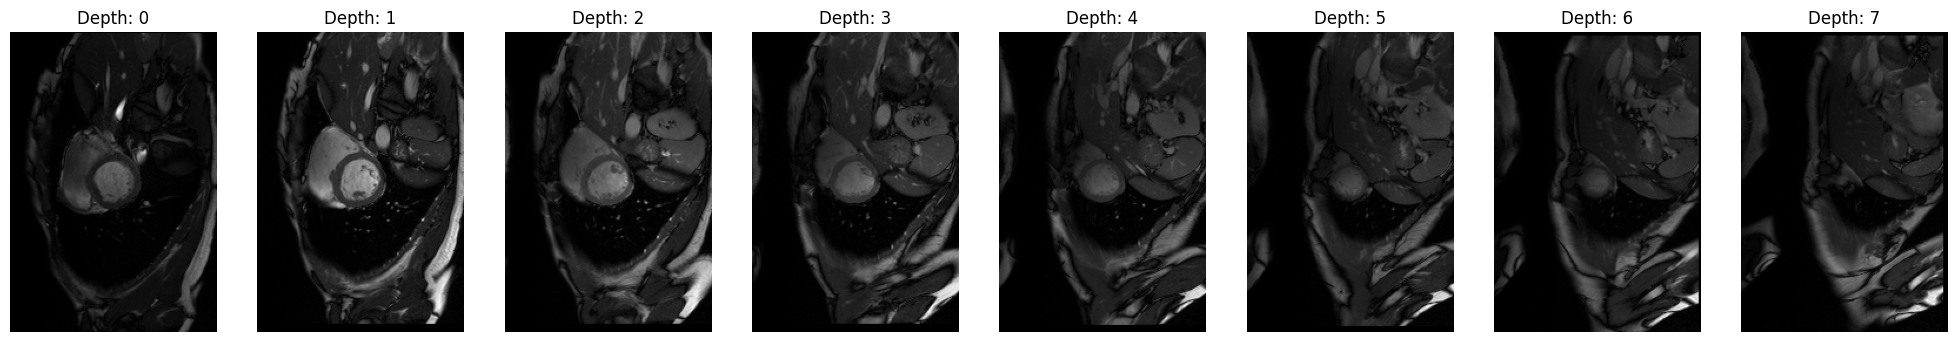


 --------------063_ES.nii--------------


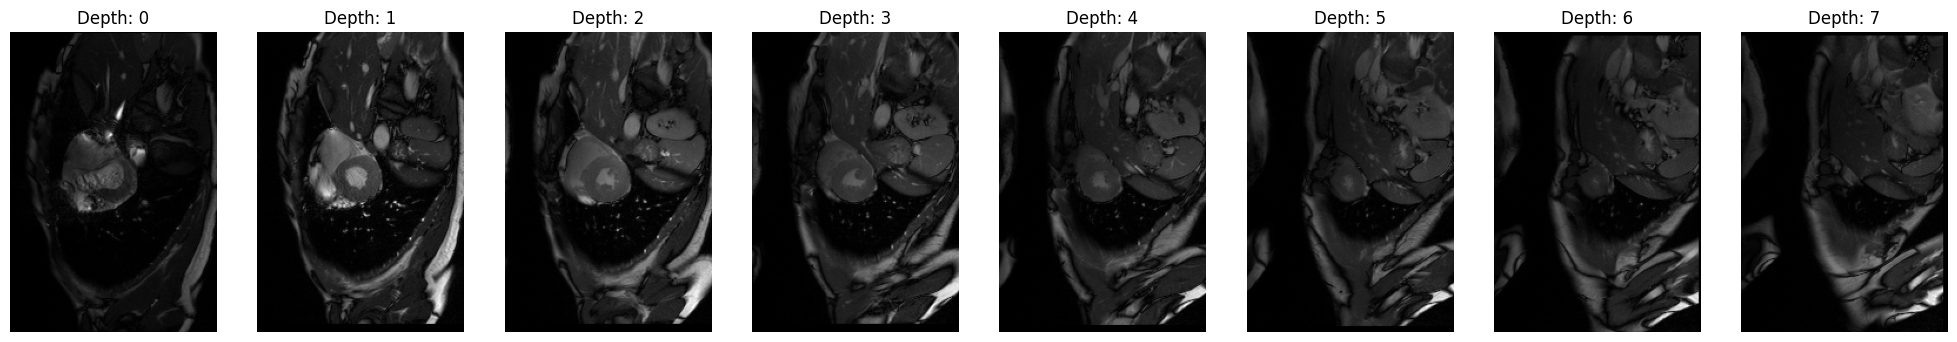


 --------------063_ES_seg.nii--------------


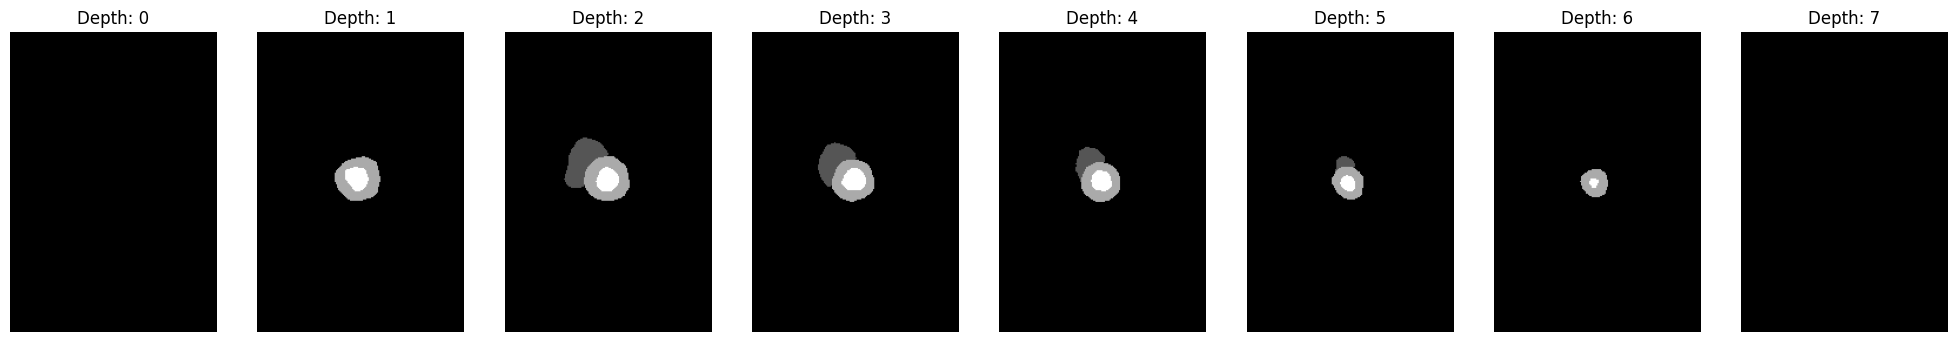


 --------------063_ED_seg.nii--------------


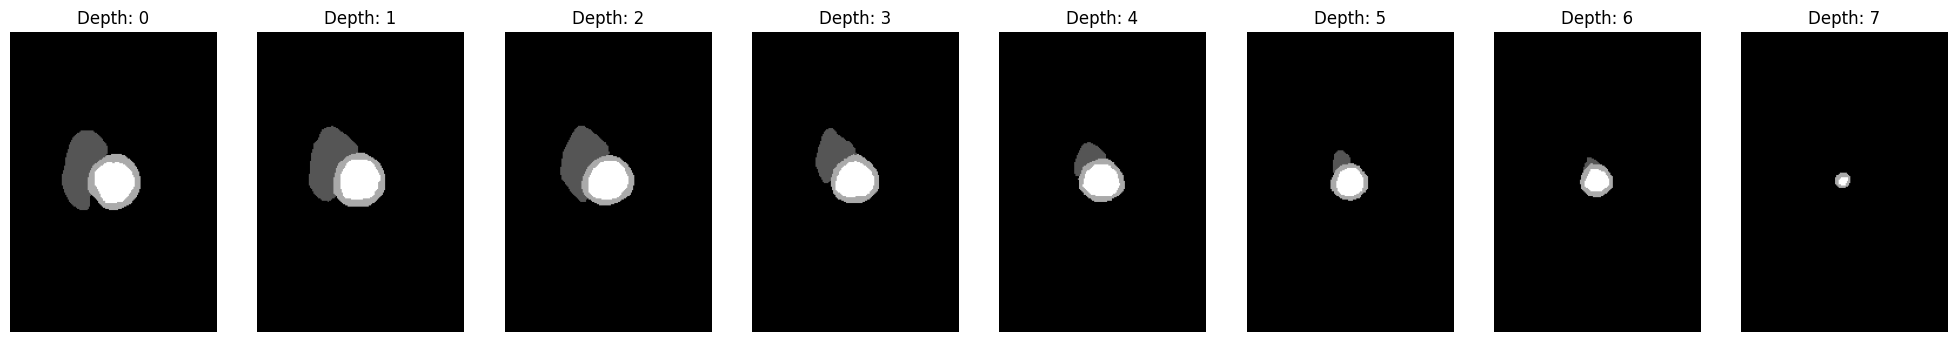

In [7]:
## Display some images from training data set
id = '063'                              # choose id of subject to display
path = os.path.join(path_train, id)     # path of the folder containing the images from id
content_path = os.listdir(path)         # the name of the images in the path (ex.: 063_ED.nii)
content_path_size = len(content_path)   # how many images are in the content_path (4 - default)

images_train_id = []                    
for i in range(content_path_size):
  train_load = nib.load(os.path.join(path + '/', content_path[i])).get_fdata()  # load the image
  print('Image: {} \tshape: {}'.format(content_path[i], train_load.shape))

  images_train_id.append(train_load)    # contains the image loaded

# Create a subplot to display each slice of all the images in {id} path
depth_size = train_load.shape[2]
for i in range(content_path_size):
  fig, ax = plt.subplots(1, depth_size, figsize=(25, 8))
  print('\n --------------{}--------------'.format(content_path[i]))
  for j in range(depth_size):
      ax[j].imshow(images_train_id[i][:,:,j], cmap='gray')  # show one single slice of each image
      ax[j].axis('off')
      ax[j].set_title('Depth: {}'.format(j))
  plt.show()

Image: 121_ES.nii 	shape: (240, 166, 8)
Image: 121_ES_seg.nii 	shape: (240, 166, 8)
Image: 121_ED.nii 	shape: (240, 166, 8)
Image: 121_ED_seg.nii 	shape: (240, 166, 8)

 --------------121_ES.nii--------------


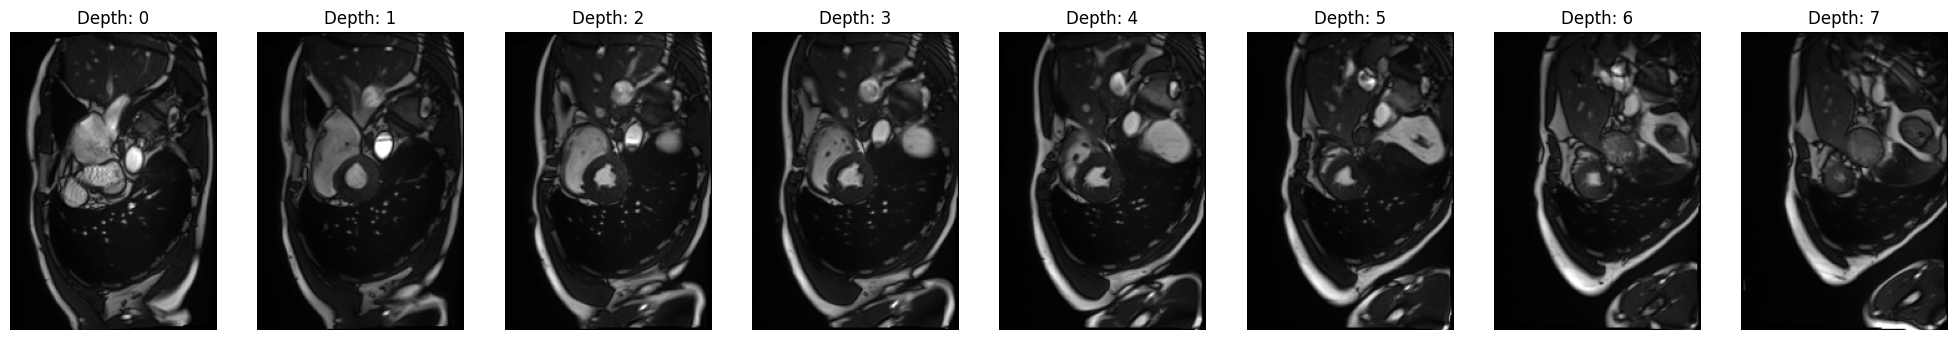


 --------------121_ES_seg.nii--------------


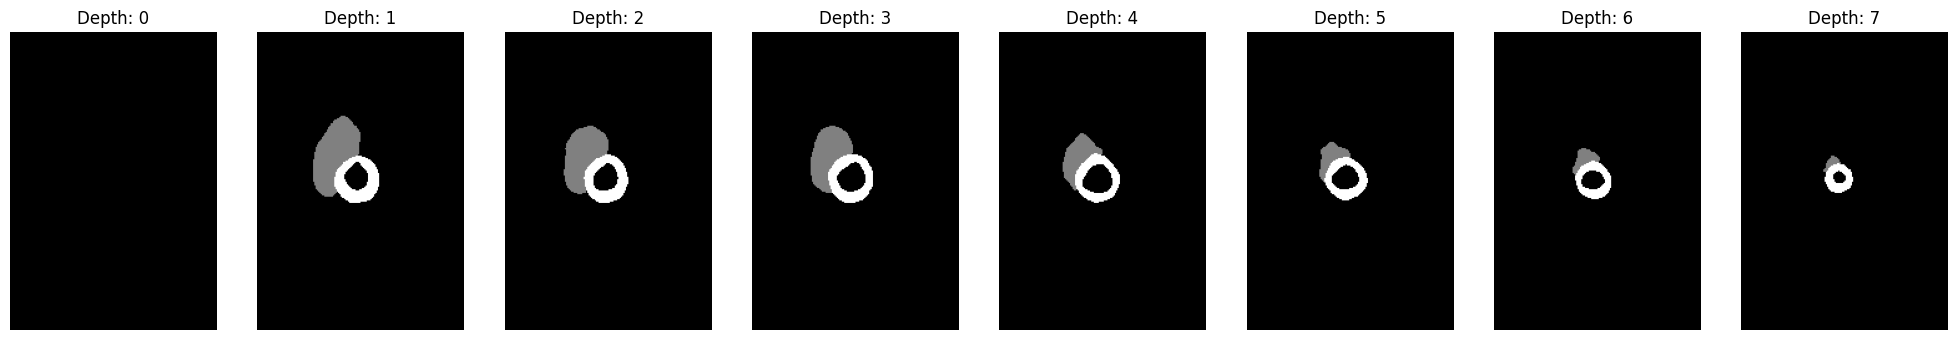


 --------------121_ED.nii--------------


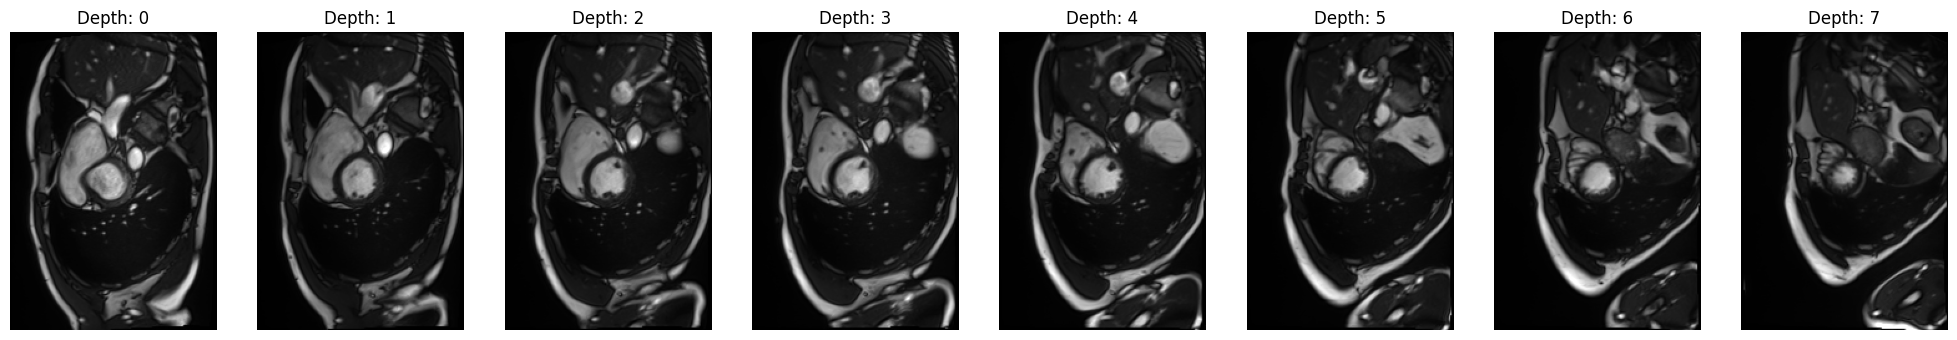


 --------------121_ED_seg.nii--------------


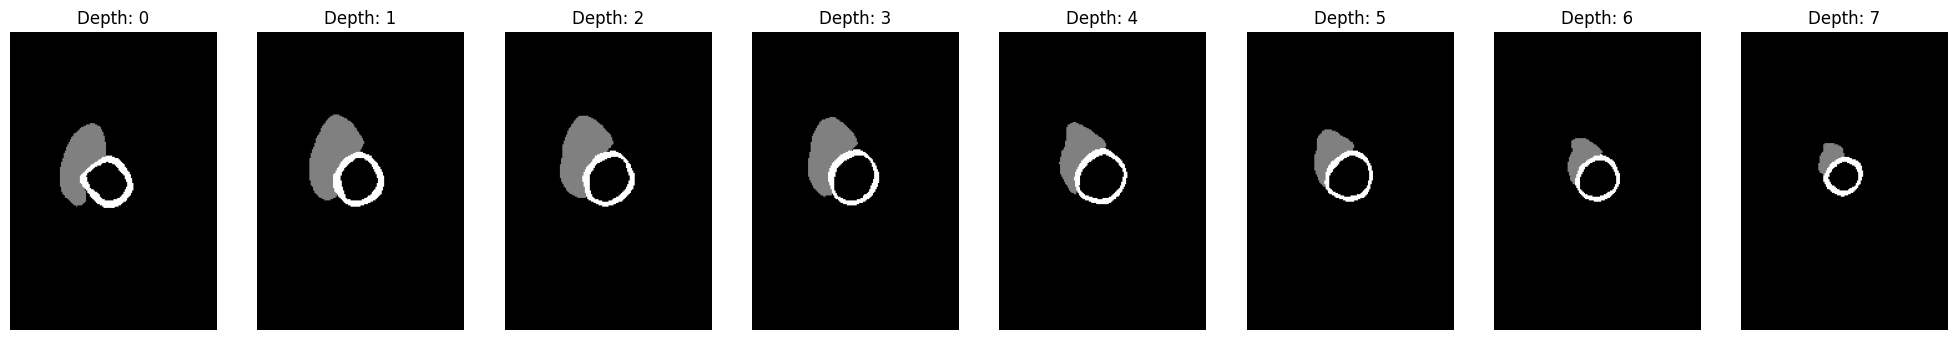

In [8]:
## Display some images from testing data set
id = '121'                              # choose id of subject to display
path = os.path.join(path_test, id)
content_path = os.listdir(path)
content_path_size = len(content_path)

images_test_id = []
for i in range(content_path_size):
  test_load = nib.load(os.path.join(path + '/', content_path[i])).get_fdata()
  print('Image: {} \tshape: {}'.format(content_path[i], test_load.shape))

  images_test_id.append(test_load)

depth_size = test_load.shape[2]
for i in range(content_path_size):
  fig, ax = plt.subplots(1, depth_size, figsize=(25, 8))
  print('\n --------------{}--------------'.format(content_path[i]))
  for j in range(depth_size):
      ax[j].imshow(images_test_id[i][:,:,j], cmap='gray')  # show one single slice of each image
      ax[j].axis('off')
      ax[j].set_title('Depth: {}'.format(j))
  plt.show()

## Data Processing

The data processing consists in trying to solve the problem of not having the segmentation of the left ventricle in the images for the test dataset. According to the articles provided for the classification, the most important features depend on this segmentation to have a good accuracy in the test dataset. 

Therefore, in this project, four methods of segmentation have been tried and the fourth one is the one chosen to extract the segmentation of the left ventricle. These are done in the **Segmentation** section.

With the segmentation of the left ventricle ready, it is possible to extract the features, done in the **Extracting features** section. 

### Segmentation

#### 1 approach

The first approach is based on this [tutorial](https://sakibreza.github.io/biomedical/part3). It contains all the steps to segment a biometical image and obtain the segmentation of the left ventricle. 

As an example to test if the approach works, it was chosen some subject and the following steps are applied:

-  Smooth the pixels' intensity of the image using a median filter
-  Use a threashold and a mask to select only the high intensity pixels
-  Create labels for the pixels in the mask
-  Choose the label that matches the left ventricle (usually the one located in the center of the image). 

This approach is very close to the one used in the IMA204 practical segmentation work, with slight differences. However, when tested with the entire test data set, it does not segment correctly. An example of this is subject `124`, who has the mask not only with the left ventricle, but also with other elements of the heart that are undesirable for this task.

Num. Labels: 19


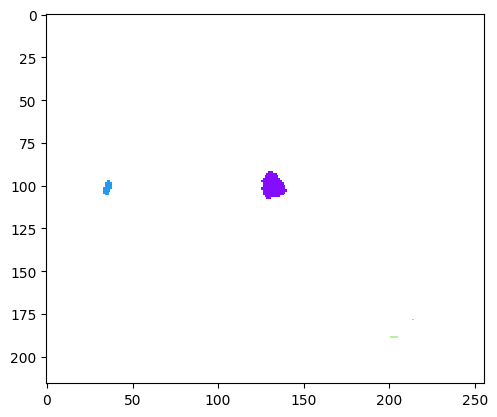

In [9]:
## First approach for segmentation
id = '124'    # choose id of subject to display
path = os.path.join(path_test, id)
test = nib.load(os.path.join(path + '/', '124_ES.nii')).get_fdata()       # image of the ES that is not segmented
test2 = nib.load(os.path.join(path + '/', '124_ES_seg.nii')).get_fdata()  # image of the ES that is segmented

# choose an slice of the images to test the approach
test = test[:,:,2]
test2 = test2[:,:,2]

# Smooth intensity values
im_filt = ndi.median_filter(test, size=7)

# Select high-intensity pixels
mask_start = np.where(im_filt>60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:',nlabels)

# Create a `labels` overlay
overlay = np.where(labels>13, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(overlay, cmap='rainbow', alpha=0.95)

0


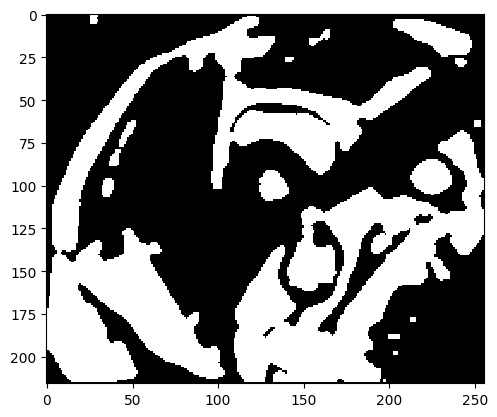

In [10]:
## Select left ventricle pixels
# select a point that matches the left ventricle in the previous image
lv_val = labels[100, 145]                          
print(lv_val)
lv_mask = np.where(labels == lv_val, 1, np.nan)   # take the labels that match the chosen point

# Overlay selected label
plt.imshow(lv_mask, cmap='gray')
plt.show()

#### 2 approach

The second approach is based on the segmentation practical work done in IMA204. It is similiar to the first approach in terms of using pre-processments to the image, but it uses instead *kmeans* to select the labels that are possible in the image.

The function `my_kmeans` is exactly the same used in the practical work. As for the pre-processing, we can apply several methods, such as filtering (gaussian filter, median filter) and threshold. In this case, the student choose the median filter. After applying the kmeans, it is also possible to have a pos-processing with morphology filters and gaussian filter. 

Even in the face of these methods, the result is very close to the one obtained from the first approach and not all the images have, necessarily the same treatment to obtain the segmentation of the left ventricle. 

In [11]:
def my_kmeans(image, k):
    """
    Parameters:
    -----------
    image: image to define the labels
    k: number of clusters
    """

    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    pixel_vals = np.float32(pixel_vals)                                         # Convert to float type only for supporting cv2.kmean
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)  # criteria
    retval, labels, centers = cv2.kmeans(
        pixel_vals, 
        k, 
        None, 
        criteria, 
        10, 
        cv2.KMEANS_PP_CENTERS
    ) 
    centers = np.uint8(centers)   # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()]             # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels                                   # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape))  # reshape data into the original image dimensions
    
    return segmented_image,segmented_labels

Yout Target_value =  64
Distance of your Target_value to Centers =  [25 27]
Your selected label (starting with 0)=  0


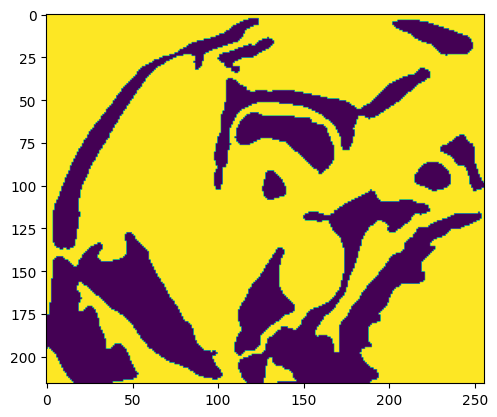

In [12]:
# Segmenting frame by frame of test images
id = '124'    # choose id of subject to display
path = os.path.join(path_test, id)
test = nib.load(os.path.join(path + '/', '124_ES.nii')).get_fdata()
im2 = nib.load(os.path.join(path + '/', '124_ES_seg.nii')).get_fdata()

# Pre-processing 
Target_value_thresh = 67.
img_median = ndimage.median_filter(test[:,:,2], size=6)
Seg_thresh = morphology.remove_small_holes(morphology.remove_small_objects(img_median > Target_value_thresh))
Seg_thresh = Seg_thresh.astype('uint8')

# Debugging part
# im = 1*(test[:,:,2] > Target_value_thresh)
# print(im)
# print(img_median)
# plt.imshow(test[:,:,0])
# print(test[:,:,0])
# print(Seg_thresh)

# kmeans
n_clusters = 2
seg_test, seg_labels = my_kmeans(Seg_thresh, n_clusters)

# display colormap image with the labels
Colormap  = plt.get_cmap('nipy_spectral', n_clusters)
#print(seg_labels.shape)
#print(seg_labels[90,:])
plt.imshow(seg_labels, cmap=Colormap)
plt.imshow(seg_test)

Seg_km_labels = morphology.label(seg_test)

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(n_clusters)
for i in range(0,n_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(test[:,:,2], Img_label_mask)
    Img_label_means[i] = tmp[0]

Target_value = cv2.mean(test[:,:,2], im2[:,:,2].astype('uint8'))
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(n_clusters))
Label_select = np.argmin(Diff)
print('Yout Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)

# Select the labels that are candidates
Img_label_select  = Seg_km_labels==(Label_select)
Img_label_select  = Img_label_select.astype('float64')

# Apply pos-processing
Img_label_select_smooth = gaussian(Img_label_select,
                                   sigma=2, 
                                   preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.5, min_size=60,connectivity=1),
    area_threshold=50)

plt.imshow(Img_label_select)

#### 3 approach 

The third approach is based on the article *Fast Fully Automatic Multiframe Segmentation of Left Ventricle in Cardiac MRI Images Using Local Adaptive K-Means Clustering and Connected Component Labeling*, from A. Bhan et al., available in this [link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7095354).

It uses some steps to obtain a segmented image of the left ventricle, that is successful, as it is possible to see through in following cells. The last image in the section represents a good approximation for the left ventricle. 

The following image represents the steps that the article recommends:

1.  Adaptive k-means clustering
2.  Local Otsu thresholding
3.  Connected component labeling
4.  Noise removal using some filter
5.  Heuristic segmentation
6.  Boundary detection<br>
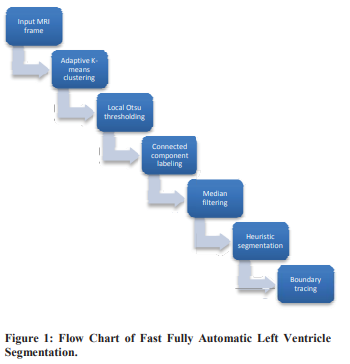

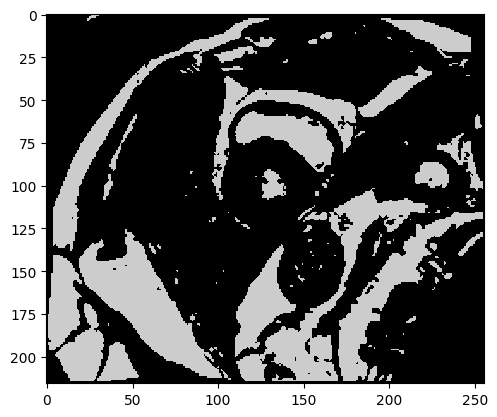

In [13]:
# Testing approach from Fast Fully Automatic Multiframe Segmentation
# of Left Ventricle in Cardiac MRI Images Using
# Local Adaptive K-Means Clustering and
# Connected Component Labeling

# Input mri frame
id = '124'    # choose id of subject to display
path = os.path.join(path_test, id)
test = nib.load(os.path.join(path + '/', '124_ES.nii')).get_fdata()       # load image from id 124 that is not segmented
test2 = nib.load(os.path.join(path + '/', '124_ES_seg.nii')).get_fdata()  # load image from id 124 that is segmented

# Select one slice of the images to test the approach
test = test[:,:,2]
test2 = test2[:,:,2]

# Kmeans clustering
n_clusters = 2
seg_test, seg_labels = my_kmeans(test, n_clusters)

plt.imshow(seg_test, cmap=Colormap)

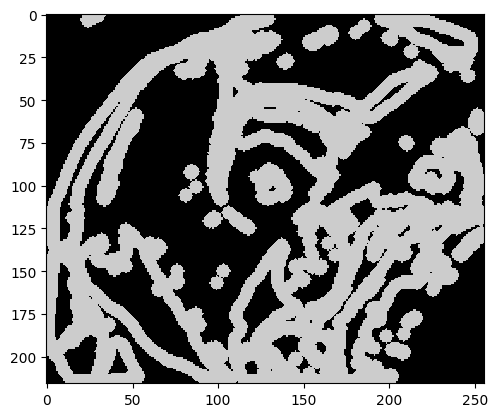

In [14]:
# Local Otsu thresholding
radius = 4
selem = morphology.disk(radius)
local_otsu = rank.otsu(seg_test, selem)       # module from skimage

plt.imshow(local_otsu, cmap=Colormap)

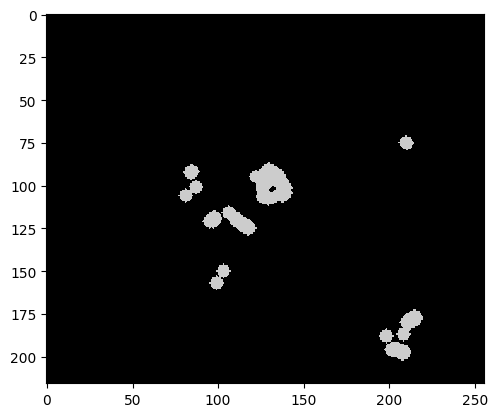

In [15]:
# Connected component labeling
ccl = cv2.connectedComponentsWithStats(local_otsu, labels=2, stats=cv2.CV_32S)   # apply component analysis
(totalLabels, label_ids, values, centroid) = ccl

plt.imshow(label_ids, cmap=Colormap)

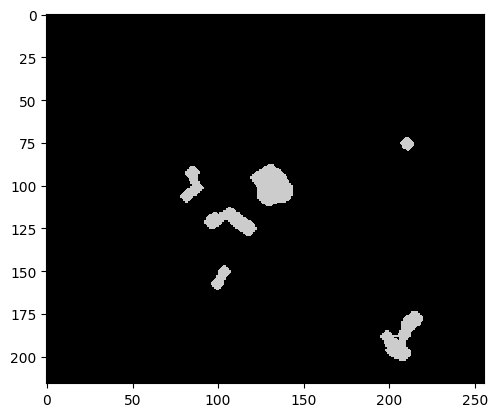

In [16]:
# Noise removal
img_median = ndimage.median_filter(label_ids, size=6)

plt.imshow(img_median, cmap=Colormap)

8


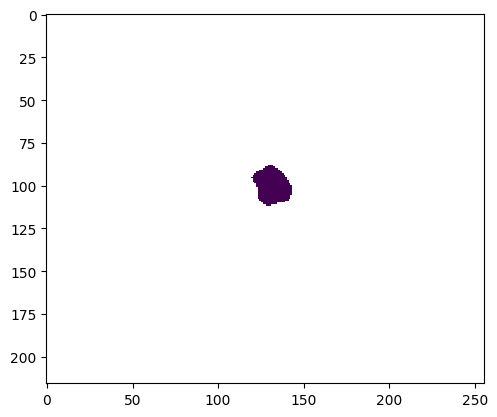

In [17]:
# Heuristic Segmentation
lv_val = label_ids[int(img_median.shape[0]/2), int(img_median.shape[1]/2)]
print(lv_val)
lv_mask = np.where(img_median == lv_val, 1, np.nan)
plt.imshow(lv_mask)   # final result

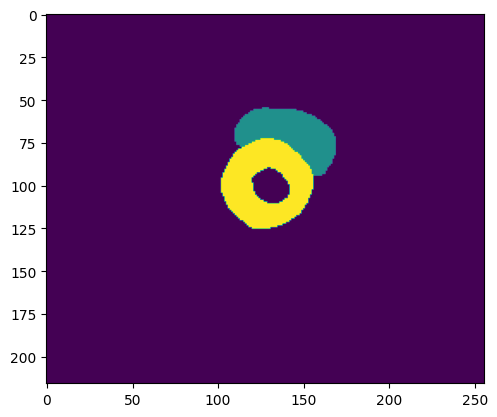

In [18]:
# Display segmented image without left ventricle for comparison
plt.imshow(test2)

In [19]:
## Define function to generalize the method
def segmentTestImages(im, sl, n_clusters=2, radius_disk=4, kernel_filter=6):
  # Kmeans clustering
  seg_im, seg_labels = my_kmeans(im[:,:,sl], n_clusters)

  # Local Otsu thresholding
  seg_morpho= morphology.disk(radius_disk)
  local_otsu = rank.otsu(seg_im, seg_morpho)

  # Connected component labeling
  ccl = cv2.connectedComponentsWithStats(local_otsu, labels=n_clusters, stats=cv2.CV_32S)   # apply component analysis
  (totalLabels, label_ids, values, centroid) = ccl

  # Noise removal
  img_median = ndimage.median_filter(label_ids, size=kernel_filter)

  # Heuristic Segmentation
  lv_val = label_ids[int(img_median.shape[0]/2), int(img_median.shape[1]/2)]  # take the most central element
  lv_mask = np.where(img_median == lv_val, 1, np.nan)

  return lv_mask

Since the result obtained from this approach was considered very close from the desired segmentation of the left ventricle, it was created the function `segmentTestImages` to segment the other images present in the test dataset. However, when testing the method, it does not work for all the images, leaving some traces from other parts of the heart in the segmentation.

#### 4 approach

The forth approach is not exactly a segmentation, but it is a manner to obtain the region that corresponds to left ventricle, since the previous methods did not work entirely fine with the dataset. 

It consists of using a morphological filter to fill the holes in the image. In this case, it will take the segmented image (contrary to the other methods that take the original image) and will fill the part that is not the background, leaving two different values. To obtain the left ventricle, the original segmented image is subtracted from the one from the morphological filter and multiplied by -1 (obtained from testing, to correctly take the left ventricle and not the myocardium as 1). 

A function is created to generalize the process and use with the rest of the images to extract features in the following section.

[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0

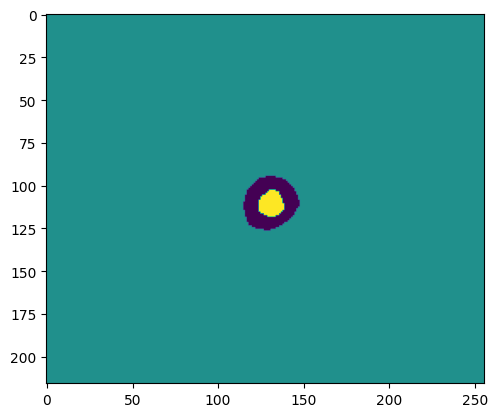

In [20]:
id = '120'          # choose id of subject to display
path = os.path.join(path_test, id)
test = nib.load(os.path.join(path + '/', '120_ES_seg.nii')).get_fdata()

test = test[:,:,4]                              # select slice to test
im = ndi.binary_fill_holes(test)                # apply morphological filter to fill holes
im2 = -1 * (test - im)                          # calculation to take the correct left ventricle mask

plt.imshow(im2)     # lv with value 1 in this case
print(im2[112,:])   # print mask

In [21]:
def segmentLeftVentricule(im):
  """
  Return a mask for the left ventricle

  Parameters:
  -----------
  im: segmented image of a slice provided from dataset

  Returns:
  seg_im: mask for the left ventricle in a slice
  """
  
  ima = ndi.binary_fill_holes(im)
  seg_im = -1 * (im - ima)

  return seg_im

### Extracting Features

To extract the features, the article "Densely Connected Fully Convolutional Network for Short-Axis Cardiac Cine MR Image Segmentation and Heart Diagnosis Using Random Forest" from M. Khened et al. was used (provided in this [link](https://link.springer.com/chapter/10.1007/978-3-319-75541-0_15)). It uses the following features for classification:

-  Ejection fraction of left ventricle and right ventricle
-  Volume of the left ventricle at end systole and end diastoles phases
-  Volume of the right ventricle at end systole and end diastole phases
-  Mass of the myocardium at end diastole and its volume at end systole
-  Patient height and weight

These attributes are calculated for both training and testing data set and are explained the calculations in the following cells. 

Before the extraction of the features itself, it is important to have the masks for each part segmented for the heart, left and right ventricles and myocardium. That is what the part **Extracting the masks** is responsible for. After that, the volumes from all these cavities in end systole and end diastole are calculated to, then, use it in the feature extraction.

**Extracting the masks**

In [61]:
def extractImagesSegmented(im_str):
  """
  Function responsible for separating the segmented 
  images from ES and ED for a given subject

  Parameters:
  -----------
  im_str: 4 image names for the respective subject

  Returns:
  -----------
  seg_ED: end diastole image names for the subject
  seg_ES: end systole image names for the subject
  id: id of the subject
  """

  seg_ED = []  
  seg_ES = []  
  id = im_str[0][:3]  # take the first three characters of the first image string

  # Search for the correspondent characters for 'ED' or 'ES' and 'seg'
  seg_ED = [im for im in im_str if im[5] == 'D' and im[7] == 's']
  seg_ES = [im for im in im_str if im[5] != 'D' and im[7] == 's']

  return seg_ED, seg_ES, id

In [62]:
## Take all the masks from training dataset

# contains all the subjects - images names
size_train = len(train_subjects)  

# lists to append the segmented images
train_ED_seg_images = []          
train_ES_seg_images = []          

# list to append the ids of the subjects
id_subjects_train = []            

# lists to append the size of the voxel in each segmented image in 3D 
voxel_size_seg_train_ED = []      
voxel_size_seg_train_ES = []

for i in range(size_train):
    seg_ED, seg_ES, id = extractImagesSegmented(train_subjects[i])

    # load the segmented images
    seg_ED_im = nib.load(os.path.join(path_train + id, seg_ED[0]))  # seg_ED[0] to take only the element instead of a list
    seg_ES_im = nib.load(os.path.join(path_train + id, seg_ES[0]))
    
    # append the images, ids and the depths
    train_ED_seg_images.append(seg_ED_im)
    train_ES_seg_images.append(seg_ES_im)
    id_subjects_train.append(id)
    voxel_size_seg_train_ED.append(seg_ED_im.header.get_zooms())    # get_zooms() gets the voxel sizes in millimeters
    voxel_size_seg_train_ES.append(seg_ES_im.header.get_zooms())

The process for the test images is strictly the same when it comes to the same images, i.e. myocardium and right ventricle segmented images, voxel size and ids. However, to extract the left ventricle masks, it is used the function defined above, `segmentLeftVentricule`, that returns the mask for the left ventricle for each slice. Because of that, each one of them is added to the variables `slice_images_ED` and `slice_images_ES` in a loop, considering `j` the corresponding slice.

The function `get_fdata()` returns a float data array for the image, not an nibabel.nifti1.Nifti1Image.

In [63]:
## Take all the masks from testing dataset

# Same variables as before, but for testing
size_test = len(test_subjects)
test_ED_seg_images = []
test_ES_seg_images = []
id_subjects_test = []
voxel_size_seg_test_ED = []
voxel_size_seg_test_ES = []

# additional lists for getting the left ventricle segmentations
test_ED_seglv_images = []     
test_ES_seglv_images = []

for i in range(size_test):
    # extract images that are already segmented
    seg_ED, seg_ES, id = extractImagesSegmented(test_subjects[i])
    
    seg_ED_im = nib.load(os.path.join(path_test + '/' + id, seg_ED[0]))
    seg_ES_im = nib.load(os.path.join(path_test + '/' + id, seg_ES[0]))

    test_ED_seg_images.append(seg_ED_im)
    test_ES_seg_images.append(seg_ES_im)
    id_subjects_test.append(id)    
    voxel_size_seg_test_ED.append(seg_ED_im.header.get_zooms())
    voxel_size_seg_test_ES.append(seg_ES_im.header.get_zooms())
    
    # obtain shape to have the slices information
    shape_seg_ED = seg_ED_im.shape
    shape_seg_ES = seg_ES_im.shape
    
    slice_images_ED = np.zeros(shape=(shape_seg_ED))
    slice_images_ES = np.zeros(shape=(shape_seg_ES))
    
    # obtain the segmented left ventricle
    for j in range(shape_seg_ED[2]):
      slice_images_ED[:,:,j] = segmentLeftVentricule(seg_ED_im.get_fdata()[:,:,j])    
    test_ED_seglv_images.append(slice_images_ED)

    for j in range(shape_seg_ES[2]):
      slice_images_ES[:,:,j] = segmentLeftVentricule(seg_ES_im.get_fdata()[:,:,j])
    test_ES_seglv_images.append(slice_images_ES)

The function `extractFeaturesFromSegmentedImages` takes the information provided in the guide from the challenge to identify the elements in the segmented image, in this case: 

$ 1 → $ **right ventricule**

$ 2 → $ **myorcardium**

$ 3 → $ **left ventricule**

and the informations from the `im_seg_lev`, with $1$ representing the left ventricle. At the end, all the masks contain $1$ for the desired region and $0$ from other parts.

In [64]:
def extractFeaturesFromSegmentedImages(im_seg, im_seg_lv=None):
  """
  Extract each cavity of the heart and the myocardium.
  Eliminates other elements that are not the desired ones.

  Parameters:
  -----------
  im_seg: segmented image provided in the data set
  im_seg_lv: mask of the left ventricle

  Returns:
  --------
  seg_lv: mask for the left ventricle
  seg_rv: mask for the right ventricle
  seg_myo: mask for the myocardium
  """

  if (im_seg_lv is None):                         # train dataset
      seg_lv = np.where(im_seg == 3, 1, 0)
      seg_rv = np.where(im_seg == 1, 1, 0)
      seg_myo = np.where(im_seg == 2, 1, 0)
  else:                                           # test dataset
      seg_lv = np.where(im_seg_lv == 1, 1, 0)
      seg_rv = np.where(im_seg == 1, 1, 0)
      seg_myo = np.where(im_seg == 2, 1, 0)
                 
  return seg_lv, seg_rv, seg_myo

In [65]:
## Training dataset - selection of segmented regions

# lists to append the segmented images from ED and ES and all the regions desired (LV, RV and MYO)
im_train_lv_ED = []
im_train_lv_ES = []
im_train_rv_ED = []
im_train_rv_ES = []
im_train_myo_ED = []
im_train_myo_ES = []

for i in range(size_train):
    # ED
    seg_lv, seg_rv, seg_myo = extractFeaturesFromSegmentedImages(train_ED_seg_images[i].get_fdata())
    im_train_lv_ED.append(seg_lv)
    im_train_rv_ED.append(seg_rv)
    im_train_myo_ED.append(seg_myo)

    # ES
    seg_lv, seg_rv, seg_myo = extractFeaturesFromSegmentedImages(train_ES_seg_images[i].get_fdata())
    im_train_lv_ES.append(seg_lv)
    im_train_rv_ES.append(seg_rv)
    im_train_myo_ES.append(seg_myo)

`test_ED_seglv_images` is already a data array returned from the segmentation.

In [66]:
## Testing dataset - selection of segmented regions

# lists to append the segmented images from ED and ES and all the regions desired (LV, RV and MYO)
im_test_lv_ED = []
im_test_lv_ES = []
im_test_rv_ED = []
im_test_rv_ES = []
im_test_myo_ED = []
im_test_myo_ES = []

for i in range(size_test):
    # ED
    seg_lv, seg_rv, seg_myo = extractFeaturesFromSegmentedImages(test_ED_seg_images[i].get_fdata(), test_ED_seglv_images[i])
    im_test_lv_ED.append(seg_lv)
    im_test_rv_ED.append(seg_rv)
    im_test_myo_ED.append(seg_myo)

    # ES
    seg_lv, seg_rv, seg_myo = extractFeaturesFromSegmentedImages(test_ES_seg_images[i].get_fdata(), test_ES_seglv_images[i])
    im_test_lv_ES.append(seg_lv)
    im_test_rv_ES.append(seg_rv)
    im_test_myo_ES.append(seg_myo)

**Extracting volumes**

To extract the volume from the 3D masks of each region one must take the product of the voxel size in millimeters for the end diastole and end systole and multiply by the sum of the mask of the corresponding region. The following equation resumes this explanation: $$ V[region] = \sum {mask}_{region} \times \prod voxel $$ 

The volumes that are extracted in the following cells are:
-  $V[LV]$ from $ED$
-  $V[LV]$ from $ES$
-  $V[RV]$ from $ED$
-  $V[RV]$ from $ES$
-  $V[MYO]$ from $ED$
-  $V[MYO]$ from $ES$

In [67]:
## Calculate volumes - training dataset

vol_lv_ED_train = np.zeros(shape=(size_train))
vol_lv_ES_train = np.zeros(shape=(size_train))
vol_rv_ED_train = np.zeros(shape=(size_train))
vol_rv_ES_train = np.zeros(shape=(size_train))
vol_myo_ED_train = np.zeros(shape=(size_train))
vol_myo_ES_train = np.zeros(shape=(size_train))

for i in range(size_train):
    # left ventricle
    vol_lv_ED_train[i] = np.sum(im_train_lv_ED[i]) * np.prod(voxel_size_seg_train_ED[i])
    vol_lv_ES_train[i] = np.sum(im_train_lv_ES[i]) * np.prod(voxel_size_seg_train_ES[i])

    # rigth ventricle
    vol_rv_ED_train[i] = np.sum(im_train_rv_ED[i]) * np.prod(voxel_size_seg_train_ED[i])
    vol_rv_ES_train[i] = np.sum(im_train_rv_ES[i]) * np.prod(voxel_size_seg_train_ES[i])

    # myocardium
    vol_myo_ED_train[i] = np.sum(im_train_myo_ED[i]) * np.prod(voxel_size_seg_train_ED[i])
    vol_myo_ES_train[i] = np.sum(im_train_myo_ES[i]) * np.prod(voxel_size_seg_train_ES[i])

In [68]:
## Calculate volumes - testing dataset

vol_lv_ED_test = np.zeros(shape=(size_test))
vol_lv_ES_test = np.zeros(shape=(size_test))
vol_rv_ED_test = np.zeros(shape=(size_test))
vol_rv_ES_test = np.zeros(shape=(size_test))
vol_myo_ED_test = np.zeros(shape=(size_test))
vol_myo_ES_test = np.zeros(shape=(size_test))

for i in range(size_test):
    # left ventricle
    vol_lv_ED_test[i] = np.sum(im_test_lv_ED[i]) * np.prod(voxel_size_seg_test_ED[i])
    vol_lv_ES_test[i] = np.sum(im_test_lv_ES[i]) * np.prod(voxel_size_seg_test_ES[i])

    # rigth ventricle
    vol_rv_ED_test[i] = np.sum(im_test_rv_ED[i]) * np.prod(voxel_size_seg_test_ED[i])
    vol_rv_ES_test[i] = np.sum(im_test_rv_ES[i]) * np.prod(voxel_size_seg_test_ES[i])

    # myocardium
    vol_myo_ED_test[i] = np.sum(im_test_myo_ED[i]) * np.prod(voxel_size_seg_test_ED[i])
    vol_myo_ES_test[i] = np.sum(im_test_myo_ES[i]) * np.prod(voxel_size_seg_test_ES[i])

**Calculate the Ejection fraction of left ventricle and right ventricle**

The value is given in percentage.
-  $EF = \frac{V[LV]_{ED} - V[LV]_{ES}}{V[LV]_{ED}}$

In [69]:
## Calculate EF for training dataset

ef_train = np.zeros(shape=(size_train))
for i in range(size_train):
    ef_train[i] = 100 * (vol_lv_ED_train[i] - vol_lv_ES_train[i]) / vol_lv_ED_train[i]

In [70]:
## Calculate EF for testing dataset

ef_test = np.zeros(shape=(size_test))
for i in range(size_test):
    ef_test[i] = 100 * (vol_lv_ED_test[i] - vol_lv_ES_test[i]) / vol_lv_ED_test[i]

**Calculate the Mass of the myocardium at end diastole**

-  $M[MYO]_{ED} = V[MYO]_{ED} \times \rho[MYO]_{ED}$

In [71]:
density_myo = 0.001055  # assumed value for density in g/mm3

In [72]:
## Calculate the mass for training dataset

m_train = np.zeros(shape=(size_train))
for i in range(size_train):
    m_train[i] = vol_myo_ED_train[i] * density_myo

In [73]:
## Calculate the mass for testing dataset

m_test = np.zeros(shape=(size_test))
for i in range(size_test):
    m_test[i] = vol_myo_ED_test[i] * density_myo

**Capture patient height and weight**

In [74]:
## Height and Weight for training

h_train = np.array(meta_data_train['Height'])
w_train = np.array(meta_data_train['Weight'])

## Height and Weight for testing

h_test = np.array(meta_data_test['Height'])
w_test = np.array(meta_data_test['Weight'])

## Training methods

Before training any method, one must have the data to feed the desired approach. In this case, there are three important variables:

-  `X_train`: contains all the 10 features obtained in the previous cells for the training data set.
-  `X_test`: contains the features for the test data set.
-  `y_train`: containins the assigned categories for each subject in the training data set. 

Since the test labels are not provided, the goal of the methods tried here is to obtain the best value with the training data set to have a good prevision on the testing labels.

There are also other specified variables, such as `N` and `M` to facilitate the use in the methods, giving the number of subjects in the training data set and the number of ROIs (Return on Investments), i.e. the features considered.

In [36]:
# create an array of shape (n_samples, n_features)
X_train = np.vstack([vol_lv_ED_train, vol_lv_ES_train, 
                     vol_rv_ED_train, vol_rv_ES_train,
                     vol_myo_ED_train, vol_myo_ES_train,
                     ef_train, m_train, h_train, w_train]).T

X_test = np.vstack([vol_lv_ED_test, vol_lv_ES_test, 
                    vol_rv_ED_test, vol_rv_ES_test,
                    vol_myo_ED_test, vol_myo_ES_test,
                    ef_test, m_test, h_test, w_test]).T

y_train = np.array(meta_data_train['Category'])

N,M = X_train.shape                                     # number subjects and ROIs
class_names = ["Healthy control",                       # y = 0
               "Myocardial infarction",                 # y = 1
               "Dilated cardiomyopathy",                # y = 2
               "Hypertrophic cardiomyopathy",           # y = 3
               "Abnormal right ventricle"]              # y = 4

One of the first steps in classification is data preprocessing. Two different approaches are used here to test and see if the results are changed. The normalization of the data will take into account the elimination of outliers in the data set, restricting it to a certain range. In contrast, standardization will centralize the data by removing the mean and scaling it with the standard deviation. It can be a good idea when the ranges of the data are very different from each other, which can affect the gradient descent, for example.

This project will test these cases and see if the data is in one of them.

In [37]:
# Data pre-processing
normalizer = MinMaxScaler()
scaler = StandardScaler()

# Normalization of the data
normalizer.fit(X_train)
X_train_normalize = normalizer.transform(X_train)
X_test_normalize = normalizer.transform(X_test)

# Standardization of the data
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

### Random Forests

As suggested by "[Automatic Segmentation and Disease
Classification Using Cardiac Cine MR Images](https://link.springer.com/chapter/10.1007/978-3-319-75541-0_11)" by J. M. Wolterink et al., the first method decided to test is *Random Forests*.

The steps followed here are similar to the ones made in the practical work about this subject. The first step is to use cross validation to search for the best parameters to use in the function and obtain the best result. In this case, it was tested with `n_estimators`, `min_samples_leaf` and `max_features`, possible parameters indicated in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) of `sklearn.ensemble` for Random Forest Classifier. 

In [38]:
# Initialize the classifier
RF = RandomForestClassifier(random_state=0)

# search for best hyperparameters
p_grid_RF = {'n_estimators': [10,15,20,25,30],
             'min_samples_leaf': [2,3,4,5,6], 
             'max_features': ['sqrt','log2']
             }
grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)  # cross validation for searching
grid_RF.fit(X_train_normalize, np.ravel(y_train))                                     # fit the model to train

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Best Validation Score: 0.86
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 15}


**Test importance of features**

Before making the prediction with the best parameters obtained, the student decided to check which are the most important features for the classification. As expected, considering the pointed article and the other provided for classification, the most important feature is, in fact, the "Ejection Fraction".

"Three most important features according to the Random Forest classifier: left
ventricular ejection fraction (LV EF)".

In [39]:
## Obtain the most important features
# Code based on class TP - Trees
best_params = grid_RF.best_params_
RF = RandomForestClassifier(
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    n_estimators=best_params["n_estimators"], 
    random_state=0)
RF.fit(X_train_normalize,y_train)                       # train Random Forests

# Select important features
importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], y_train[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 6 representing 2 (0.287521)
2. feature 3 representing 2 (0.203238)
3. feature 1 representing 2 (0.174772)
4. feature 0 representing 2 (0.103448)
5. feature 4 representing 2 (0.069391)
6. feature 5 representing 2 (0.064589)
7. feature 7 representing 2 (0.051524)
8. feature 2 representing 2 (0.025873)
9. feature 8 representing 2 (0.014022)
10. feature 9 representing 2 (0.005621)


**Prediction**

With the method trained, it is possible to predict the labels of the testing data set using the `predict` function available in the Random Forest Classifier. 

The training data set got $86\%$ of accuracy and the testing data set in the challenge obtained $66\%$ of accuracy with 30% of the test labels. One of the reasons for this result is an insufficient amount of data to well classify it and some features might not have been the best ones to use in the model. 

One of the possibilities to address these issues, is to test the training data set with other methods and treat the data in different ways and see if the predicting is better. If not, redo the calculations of the features and try new ones might be a good idea.

In [40]:
y_pred_RF = RF.predict(X_test_normalize)
print('Predicted labels for testing with Random Forests: \n', y_pred_RF)

Predicted labels for testing with Random Forests: 
 [2 4 0 3 4 1 0 0 4 4 3 3 0 0 3 4 2 3 1 3 4 4 3 3 0 2 2 4 2 4 1 4 3 2 3 3 1
 3 2 0 2 1 2 1 4 2 0 1 1 1]


### LDA

Linear Discriminant Analysis (LDA), along with the following methods (KNN and SVM) are the methods used in the practical works that demonstrated good results in classifying the data. Therefore, the second method to be tested is LDA.

It was used to approachs: 
-  LDA with different data pre-processings 
-  LDA with cross-validation

The first approach does not use any parameter to classify the data. Again, the codes were based in the practical works done in the classes.

In [41]:
# Fitting LDA to original data
print("Fitting LDA to training set")

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)             # train the model with LDA
y_pred_LDA = lda.predict(X_test)      # have the prediction

print("Best Validation Score: {}".format(lda.score(X_train, y_train)))

Fitting LDA to training set
Best Validation Score: 0.91


In [42]:
# Fitting LDA to normalized data
print("Fitting LDA to training set")

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_normalize, y_train)
y_pred_LDA_normalize = lda.predict(X_test_normalize)

print("Best Validation Score: {}".format(lda.score(X_train_normalize, y_train)))

Fitting LDA to training set
Best Validation Score: 0.91


In [43]:
# Fitting LDA to standardize data
print("Fitting LDA to training set")

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred_LDA_scale = lda.predict(X_test_scale)

print("Best Validation Score: {}".format(lda.score(X_train_scale, y_train)))

Fitting LDA to training set
Best Validation Score: 0.91


After testing the score of the training data set with different pre-processings, it was concluded that the data set does not need to be normalized or standardized. The range of the data is coherent and it does not accomplish outliers that affect the classification. 

Another analysis that can be taken from these results is that the LDA obtained a high score compared to the Random Forest Method. Testing with the real public labels (30%), it was obtained $80\%$ of accuracy. By this result, one can tell that the data is linear separable and the classes are balanced, in other words, the number of observations in the data is equal (in fact, it is for all the subjects and features). 

In [44]:
print('Predicted labels for testing with LDA:\n', y_pred_LDA_scale)

Predicted labels for testing with LDA:
 [2 4 0 3 4 1 0 0 4 4 3 3 0 0 0 4 2 3 1 3 4 0 3 3 1 2 2 4 2 4 1 4 3 2 0 0 1
 3 2 0 2 1 2 1 4 2 0 1 1 1]


#### LDA with cross-validation

To see if it is possible to obtain better results selecting the best parameters for the LDA function with cross validation, it was coded the following cell. However, since the score with the training dataset is not higher than the $91\%$ obtained before, the student chose to not test with real labels in the challenge. One possible reason for that is that the training with the best parameters might be more complex and cause overfitting.

One possible information to point is that the scoring method used in all the methods is *accuracy*, since is the one desired for the final labels (specification in the challenge).

In [45]:
# Fitting LDA
print("Fitting LDA")

lda = LinearDiscriminantAnalysis()

params = {'solver': ['svd', 'lsqr']}  # 'eigen' caused problems in this data
grid_lda = GridSearchCV(estimator=lda, param_grid=params, scoring="accuracy", cv=5)
grid_lda.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_lda.best_score_))
print("Best params: {}".format(grid_lda.best_params_))

Fitting LDA
Best Validation Score: 0.89
Best params: {'solver': 'svd'}


### K-nearest neighbour

The third tried method that performed well in the practical work and that would be a good idea to test on this dataset is the K-nearest neighbor.

Initially, during the challenge, this method was only tried with cross-validation, and for the same reasons as explained for the LDA with cross-validation, is that it may overfit the data and decrease the score obtained with the training dataset. Since it obtained a score lower than $86\%$, it was not tested with the real labels in the challenge. 

However, the second cell in this section was added after the challenge, and it has a better result than LDA (also expected, since it was the same in the practical work). Basically, it can be explained because the data might contain some *few* features that are not completely linear - non linear decision boundaries (note that the result is not much higher than the one obtained by LDA).

In [46]:
print("Fitting K-nearest neighbour with cross validation")
neigh = KNeighborsClassifier()

params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
grid_neigh = GridSearchCV(estimator=neigh, param_grid=params, scoring="accuracy", cv=5)
grid_neigh.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_neigh.best_score_))
print("Best params: {}".format(grid_neigh.best_params_))

Fitting K-nearest neighbour with cross validation
Best Validation Score: 0.8600000000000001
Best params: {'n_neighbors': 4}


In [47]:
print("Fitting K-nearest neighbour")
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)

print("Best Validation Score: {}".format(neigh.score(X_train, y_train)))

Fitting K-nearest neighbour
Best Validation Score: 0.92


### Support Vector Machines (SVM)

The last method used in this project is the Support Vector Machines (SVMs), also a method with good classification results in the practical works. 

It obtained a score of $91\%$ with the training dataset and the warning messages are because the value of the parameter `C` - Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive - is big, but with smaller values it does not have a good classification. The student used StandardScaler(), but it does not make a lot of difference in the classification of the training data set, since the result is a lot close to the one obtained with LDA, with an small higher value. 

Testing with the real labels (30%), it obtained an accuracy of $86\%$, a better result than the one obtained with LDA. This can be explained, because SVM has an advantage, since it finds the best hyperplane that separates the data. Even if it is a linear method, it can work with non-linear data and have good results, like the KNN. 

In [79]:
# Fitting linear SVM on original data with Standardization
print("Fitting Linear SVM")

Lsvm = make_pipeline(StandardScaler(), LinearSVC()) 

params = {'linearsvc__C': [0.1, 1, 10, 100]}
Lsvm_cv_grid = GridSearchCV(Lsvm, params, cv=20, scoring='accuracy')
Lsvm_cv_grid.fit(X_train, y_train)

best_estimator = Lsvm_cv_grid.best_estimator_
y_pred_SVM = best_estimator.predict(X_test)

print("Best Validation Score: {}".format(Lsvm_cv_grid.best_score_))
print("Best params: {}".format(Lsvm_cv_grid.best_params_))

Fitting Linear SVM


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Best Validation Score: 0.9100000000000001
Best params: {'linearsvc__C': 10}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [84]:
print('Predicted labels for testing with SVM:\n', y_pred_SVM)

Predicted labels for testing with SVM:
 [2 4 0 3 4 1 0 0 4 4 3 0 0 0 0 4 2 3 1 3 4 0 3 3 1 2 2 4 2 4 1 4 3 2 0 3 1
 3 2 0 2 1 2 2 4 2 3 1 1 1]


## Export results

Section to export the predicted labels as *.csv* files.

In [51]:
def writeCsvFile(y_pred, method):
  """
  Write a csv file

  Parameters:
  -----------
  y_pred: the array of predictions
  method: method used to predict the labels

  Returns:
  --------
  name_file: the file .csv with the subjects and labels

  """
  
  name_file = 'SampleSubmission' + method + '.csv'
  
  with open(name_file, 'w', newline='') as file:
      wr = csv.writer(file)
      fields = ['Id', 'Category']

      wr.writerow(fields)
      for i in range(size_test):
          wr.writerow([id_subjects_test[i], y_pred[i]])

  return name_file

In [52]:
def downloadFile(nameFile):
  """
  Function to download the .csv file
  """
  
  files.download(nameFile)

In [53]:
downloadFile(writeCsvFile(y_pred_LDA_scale, 'LDA_scale'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
downloadFile(writeCsvFile(y_pred_SVM, 'SVM'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

In conclusion, it is possible to say that this project was a powerful tool and task to use and concretize all the concepts seen in the IMA205 course. Moreover, it allowed to work with a complex dataset to extract the features and to practice the treatment of this data before applying the methods and concepts for classification.